In [1]:
from __future__ import division
from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

Source : https://www.datascience.com/blog/intro-to-anomaly-detection-learn-data-science-tutorials

In [2]:
## Dataset location
## wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset

data = loadtxt("/Users/avkashchauhan/tools/notebooks/datasets/sunspots.txt", float)

# Information about data

The file has 3,143 rows, which contain information about sunspots collected between the years 1749-1984. Sunspots are defined as dark spots on the surface of the sun. The study of sunspots helps scientists understand the sun's properties over a period of time; in particular, its magnetic properties.

In [3]:
data

array([[  0.00000000e+00,   5.80000000e+01],
       [  1.00000000e+00,   6.26000000e+01],
       [  2.00000000e+00,   7.00000000e+01],
       ..., 
       [  3.14000000e+03,   2.52000000e+01],
       [  3.14100000e+03,   2.35000000e+01],
       [  3.14200000e+03,   2.16000000e+01]])

In [4]:
# 2. View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.head()

,Months,SunSpots
0,0.0,58.0
1,1.0,62.6
2,2.0,70.0
3,3.0,55.7
4,4.0,85.0


In [5]:
data_as_frame.describe

<bound method DataFrame.describe of       Months  SunSpots
0        0.0      58.0
1        1.0      62.6
2        2.0      70.0
3        3.0      55.7
4        4.0      85.0
5        5.0      83.5
6        6.0      94.8
7        7.0      66.3
8        8.0      75.9
9        9.0      75.5
10      10.0     158.6
11      11.0      85.2
12      12.0      73.3
13      13.0      75.9
14      14.0      89.2
15      15.0      88.3
16      16.0      90.0
17      17.0     100.0
18      18.0      85.4
19      19.0     103.0
20      20.0      91.2
21      21.0      65.7
22      22.0      63.3
23      23.0      75.4
24      24.0      70.0
25      25.0      43.5
26      26.0      45.3
27      27.0      56.4
28      28.0      60.7
29      29.0      50.7
...      ...       ...
3113  3113.0       3.4
3114  3114.0       0.8
3115  3115.0       0.5
3116  3116.0       1.1
3117  3117.0       2.9
3118  3118.0       4.1
3119  3119.0       0.8
3120  3120.0       1.3
3121  3121.0       1.4
3122  3122.0       0.

# Moving Average Using Discrete Linear Convolution

Convolution is a mathematical operation that is performed on two functions to produce a third function. Mathematically, it could be described as the integral of the product of two functions, after one is reversed and shifted: $f*g(t)$ = $\int_{-\infty}^{\infty} f(T)*g(t-T) dT$, where f(T) is an input function containing the quantity of interest (e.g. sunspot count at time T). g(t —T) is the weighting function shifted by an amount t. This way as t changes, different weights are assigned to the input function f(T). In our case, f(T) represents the sunspot counts at time T.  g(t —T) is the moving average kernel. 

In [6]:
# 3. Lets define some use-case specific UDF(User Defined Functions)

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

In [7]:
def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in izip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

In [8]:
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

In [9]:
# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

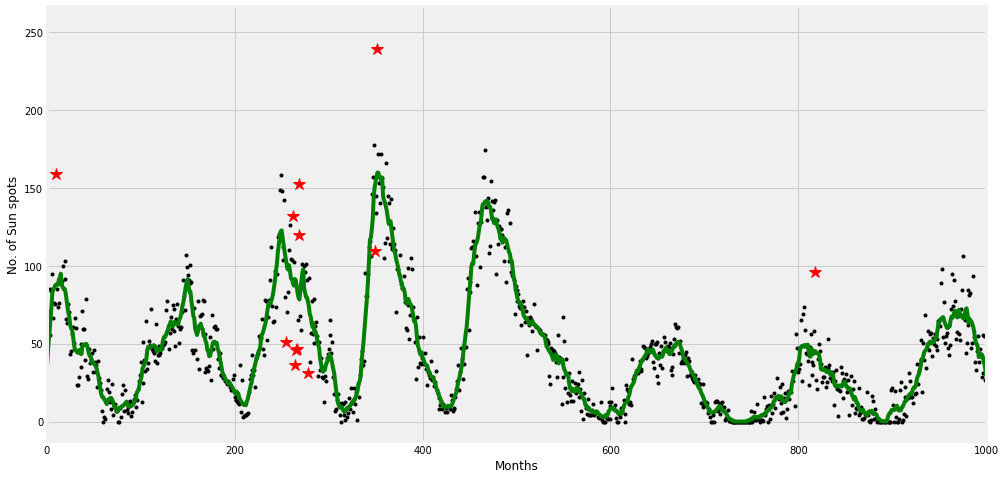

Information about the anomalies model:{'anomalies_dict': OrderedDict([(10, 158.59999999999999), (253, 142.5), (255, 51.0), (262, 132.19999999999999), (264, 36.0), (268, 152.69999999999999), (278, 31.100000000000001), (349, 109.3), (352, 238.90000000000001), (361, 165.69999999999999), (818, 96.200000000000003), (986, 93.400000000000006), (1055, 206.30000000000001), (1069, 84.799999999999997), (1172, 107.09999999999999), (1182, 52.200000000000003), (1185, 180.40000000000001), (1464, 88.299999999999997), (1735, 129.19999999999999), (1882, 107.2), (1890, 103.59999999999999), (1897, 108.2), (2023, 154.5), (2025, 72.200000000000003), (2027, 129.30000000000001), (2171, 108.0), (2274, 165.30000000000001), (2380, 201.30000000000001), (2390, 94.799999999999997), (2391, 189.69999999999999), (2503, 158.0), (2518, 152.30000000000001), (2520, 217.40000000000001), (2521, 143.09999999999999), (2527, 199.59999999999999), (2755, 58.100000000000001), (2756, 138.19999999999999), (2789, 90.900000000000006)

In [10]:
# 4. Lets play with the functions
x = data_as_frame['Months']
Y = data_as_frame['SunSpots']

# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="Months", sigma_value=3, text_ylabel="No. of Sun spots")
events = explain_anomalies(Y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

Let's see if the above anomaly detection function could be used for another use case. Let's assume that we generate a random dataset that hypothetically relates to Company A's stock value over a period of time. The x axis represents time in days (since 2013) and the y axis represents the value of the stock in dollars.

In [18]:
# Convenience function to add noise
def noise(yval):
    """ Helper function to generate random points """
    np.random.seed(0)
    return 0.2*np.asarray(yval)*np.random.normal(size=len(yval))

# Generate a random dataset
def generate_random_dataset(size_of_array=1000, random_state=0):
    """ Helps in generating a random dataset which has a normal distribution
    Args:
    -----
        size_of_array (int): number of data points
        random_state (int): to initialize a random state

    Returns:
    --------
        a list of data points for dependent variable, pandas.Series of independent variable
    """
    np.random.seed(random_state)
    y = np.random.normal(0, 0.5, size_of_array)
    x = range(0, size_of_array)
    y_new = [y_i + index**((size_of_array - index)/size_of_array) +  noise()
     for index, y_i in izip(count(), y)]
    return x, pd.Series(y_new)

ValueError: setting an array element with a sequence.

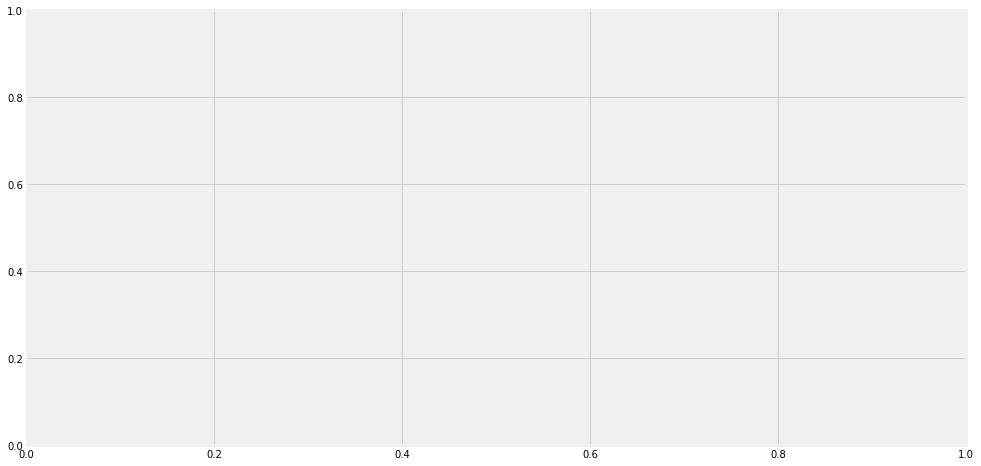

In [20]:
# Lets play
x1, y1 = generate_random_dataset()
# Using stationary standard deviation over a continuous sample replicating
plot_results(x1, y1, window_size=12, title_for_plot="Statinoary Standard Deviation",
                    sigma_value=2, text_xlabel="Time in Days", text_ylabel="Value in $")

In [19]:
# using rolling standard deviation for
x1, y1 = generate_random_dataset()
plot_results(x1, y1, window_size=50, title_for_plot="Using rolling standard deviation",
             sigma_value=2, text_xlabel="Time in Days", text_ylabel="Value in $", applying_rolling_std=True)

NameError: global name 'yval' is not defined